## 学習と精度を確認する
- RF、XGBoost、LGBMで学習と精度を確認
- テキストのみで予測するパターンと、テーブルデータとして予測するパターンを追加
- 直近N年の評価をValidationデータ、それ以外を学習データとして利用
- LGBMは交差検証とOOFによる閾値最適化を実施

In [90]:
from importlib import reload

from classification import ml_token_classification_rf
from classification import ml_token_classification_xgb
from classification import ml_token_classification_lgb

from classification import ml_numerical_classification_rf
from classification import ml_numerical_classification_xgb
from classification import ml_numerical_classification_lgb

from classification import cm

from sklearn.model_selection import train_test_split

import numpy as np


In [91]:
import japanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns

# ====== パラメータ（必要に応じて変更） ======
RANDOM_SEED = 42
N_SPLITS = 5
# 列名
TEXT_COL = "description"          # テキスト列
LABEL_BINARY_COL = "eval_binary"  # 目的変数（0/1）
YEAR_COL = "eval_year"   # 年度列（数値化可能であること）
THRESHOLD = 100 # 閾値
THRESH_OBJECTIVE = "balanced_accuracy"  # 閾値最適化の指標

# テストに使う直近年数
TEST_LAST_N = 4
# cost_success_flg, duration_success_flg, total_eval
SOURCE_ORDINAL_COL = "total_eval"

In [92]:
import pandas as pd
df_ori = pd.read_csv("../df_check_ml.csv")  # ←必要ならCSV読み込み

df_ori.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

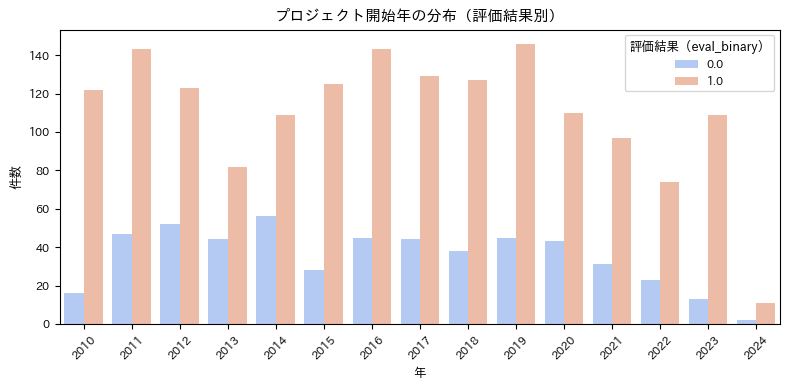

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.countplot(
    data=df_ori,
    x=YEAR_COL,
    hue="eval_binary",
    palette="coolwarm"
)
plt.title("プロジェクト開始年の分布（評価結果別）", fontsize=11)  # タイトル小さく
plt.xlabel("年", fontsize=9)                     # 軸ラベル小さく
plt.ylabel("件数", fontsize=9)
plt.xticks(rotation=45, fontsize=8)                              # x軸目盛りの文字サイズ
plt.yticks(fontsize=8)                                           # y軸目盛りの文字サイズ
plt.legend(title="評価結果（eval_binary）", fontsize=8, title_fontsize=9)
plt.tight_layout()
plt.show()

In [94]:
# 利用するテキストの特徴量を生成
df_ori['sentence'] = df_ori['background']+df_ori['description']

In [95]:
## 評価がないレコードを除外
print(df_ori['eval_binary'].isnull().sum())
df_ori = df_ori.dropna(subset=['eval_binary'])

50


In [96]:
df_ori = df_ori.rename(columns={
  LABEL_BINARY_COL: "label",
})

In [97]:
## textがないレコードを除外
print(df_ori['sentence'].isnull().sum())
df = df_ori.dropna(subset=['sentence'])

8


In [98]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)]
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)]

# RandomForest
### 実施内容だけでの予測

Accuracy: 0.8089887640449438
Precision: 0.4044943820224719
Recall: 0.5
Macro F1: 0.4472049689440994
Balanced Accuracy: 0.5
SHAP values array shape: (2, 356, 8259)


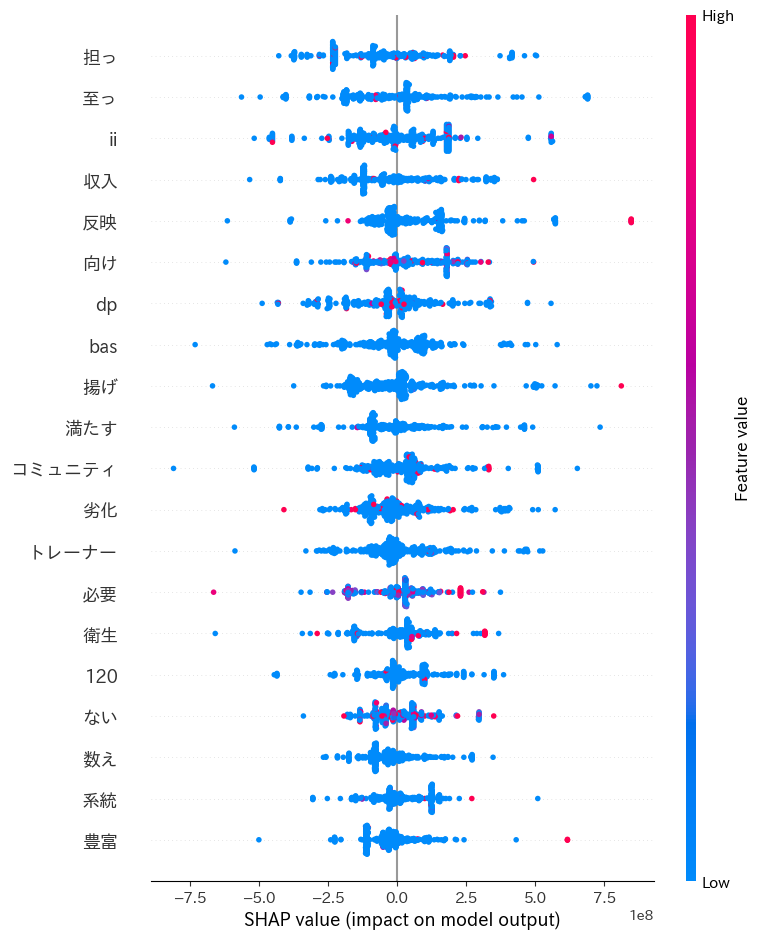

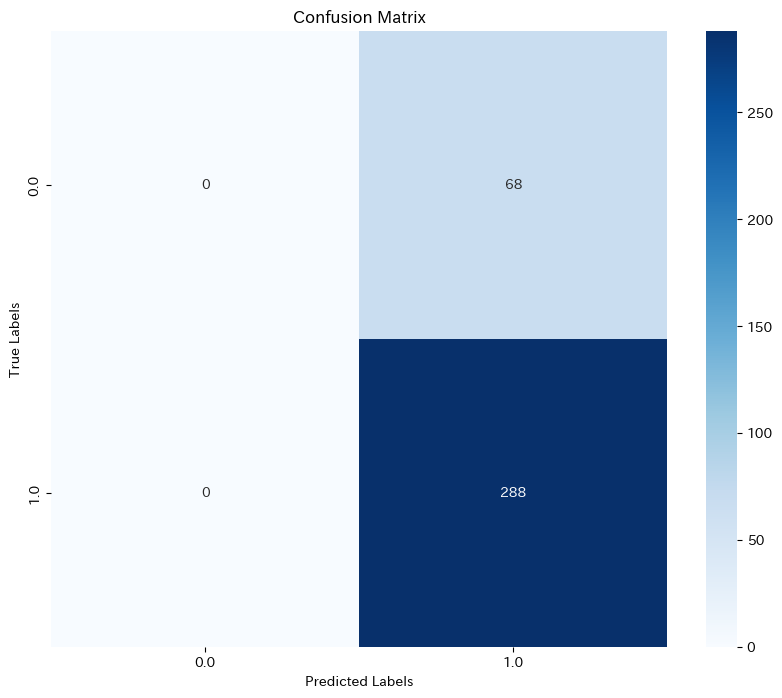

method, class, accuracy, precision, recall
proposed, all, 0.8089887640449438, 0.4044943820224719, 0.5
proposed, 0.0, non, 0.0, 0.0
proposed, 1.0, non, 0.8089887640449438, 1.0
baseline, all, 0.6909481126120439, 0.5, 0.5
baseline, 0.0, non, 0.19101123595505617, 0.19101123595505617
baseline, 1.0, non, 0.8089887640449438, 0.8089887640449438


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


In [99]:

reload(ml_token_classification_rf)

ml_token_classification_rf.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_rf.csv','results/classification/result_text_rf.csv')


# XGBoost
### 実施内容だけでの予測

[18:10:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.7612359550561798
Precision: 0.48332326283987914
Recall: 0.49295343137254904
Macro F1: 0.4743516250629701
Balanced Accuracy: 0.49295343137254904
2


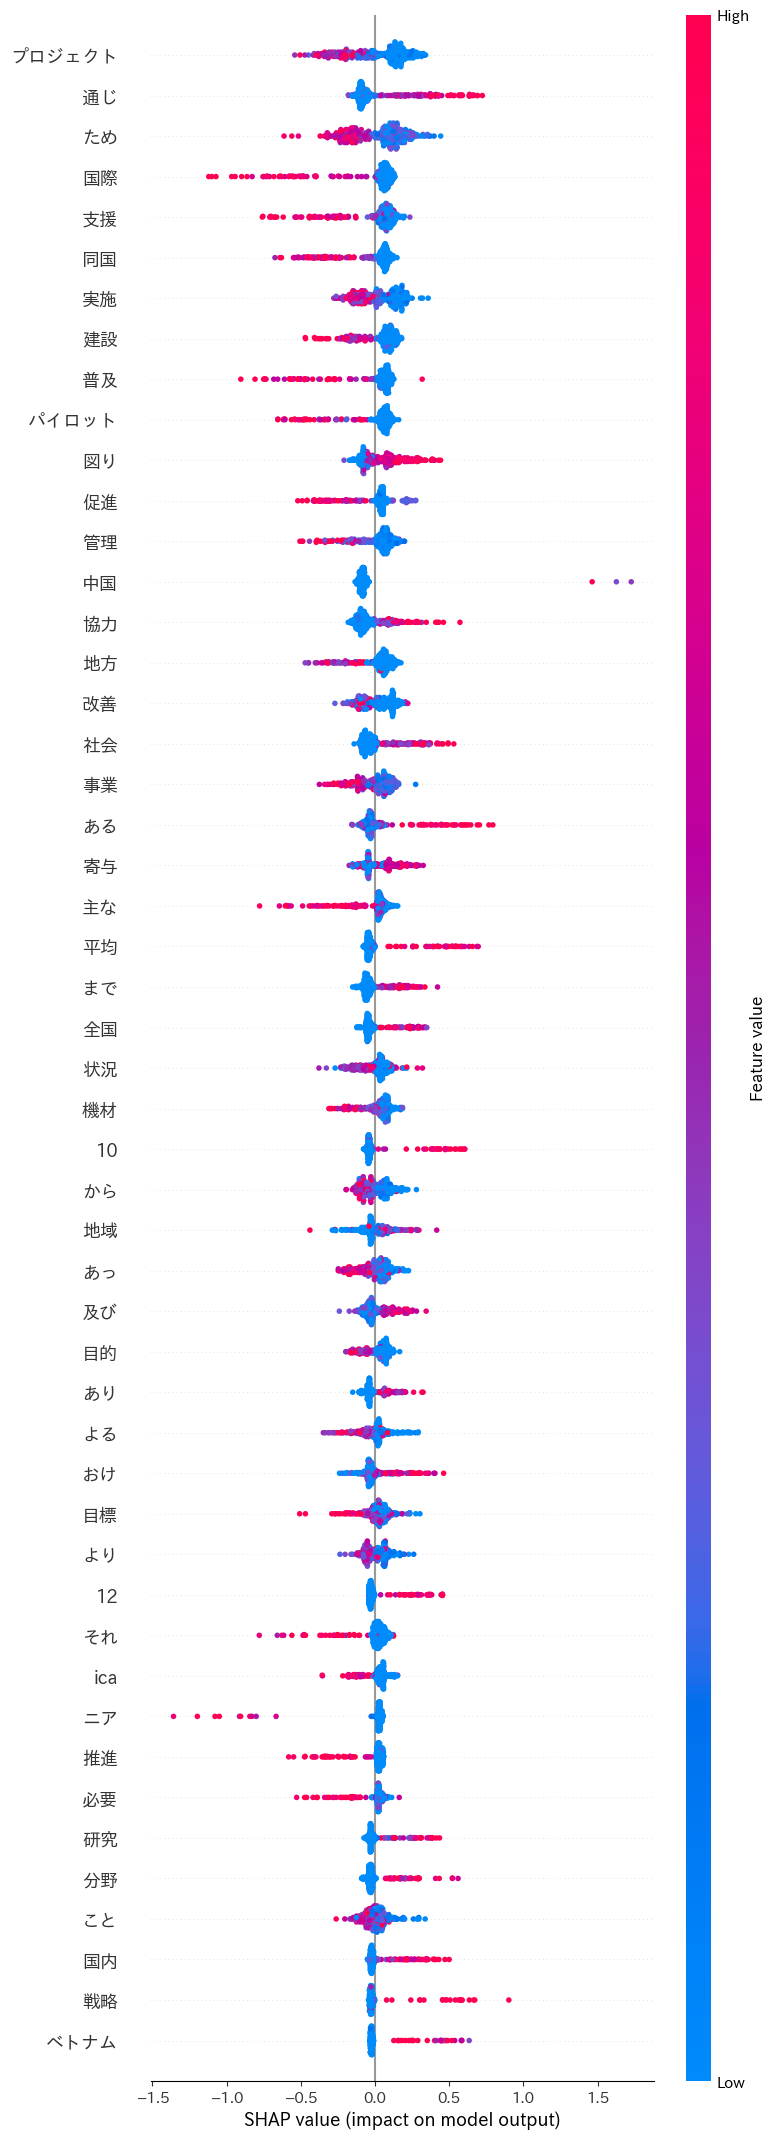

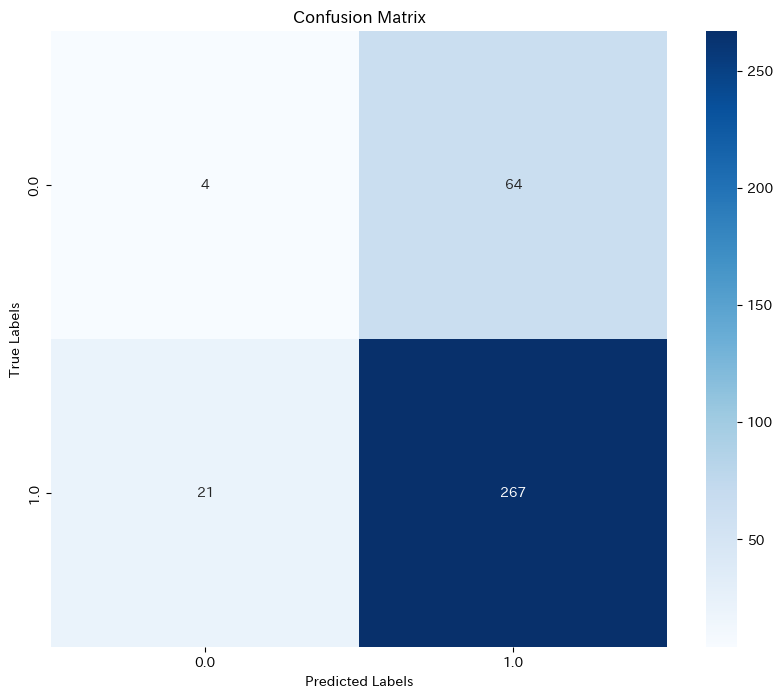

method, class, accuracy, precision, recall
proposed, all, 0.7612359550561798, 0.48332326283987914, 0.49295343137254904
proposed, 0.0, non, 0.16, 0.058823529411764705
proposed, 1.0, non, 0.8066465256797583, 0.9270833333333334
baseline, all, 0.6909481126120439, 0.5, 0.5
baseline, 0.0, non, 0.19101123595505617, 0.19101123595505617
baseline, 1.0, non, 0.8089887640449438, 0.8089887640449438


In [100]:
reload(ml_token_classification_xgb)
ml_token_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_xgb.csv','results/classification/result_text_xgb.csv')


# LighGBM
### 実施内容だけでの予測

[LightGBM] [Info] Number of positive: 1084, number of negative: 366
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52553
[LightGBM] [Info] Number of data points in the train set: 1450, number of used features: 1507
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.747586 -> initscore=1.085780
[LightGBM] [Info] Start training from score 1.085780
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


SHAP values array shape: (2, 356, 7525)


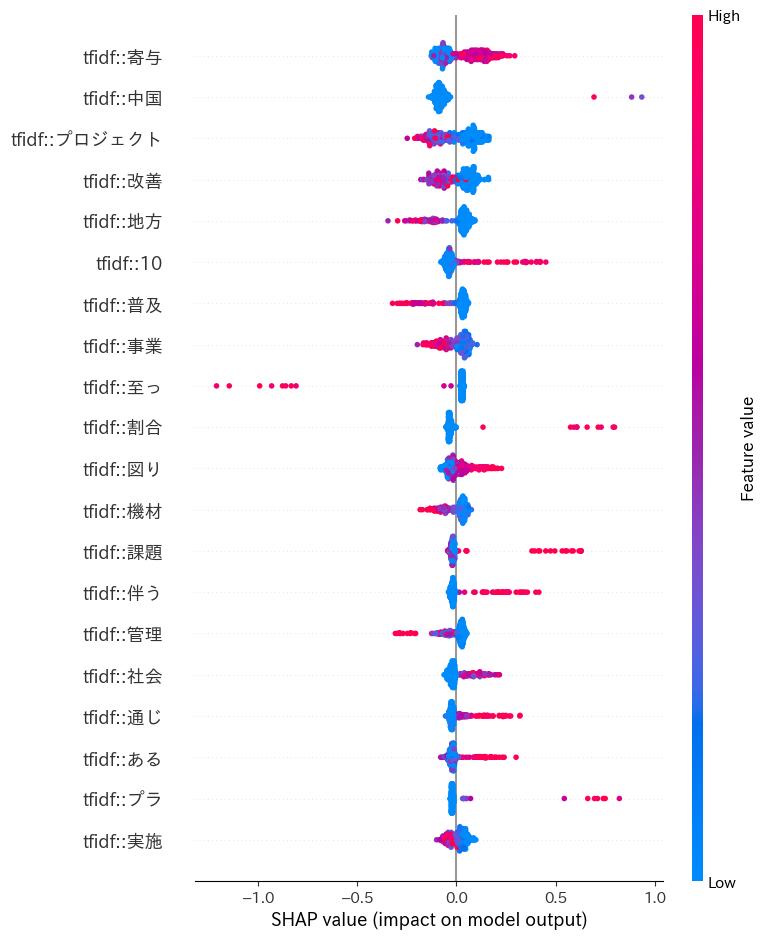

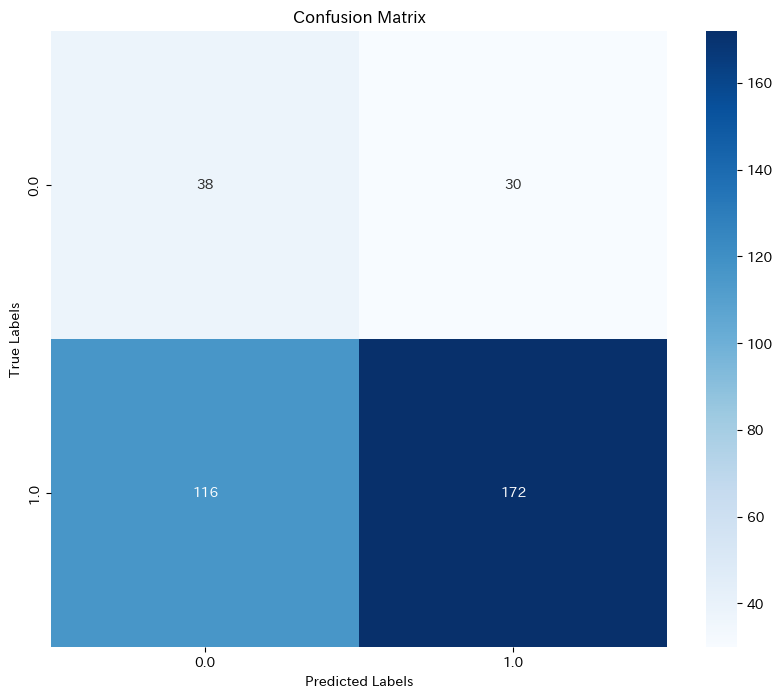

method, class, accuracy, precision, recall
proposed, all, 0.5898876404494382, 0.5491191976340491, 0.5780228758169934
proposed, 0.0, non, 0.24675324675324675, 0.5588235294117647
proposed, 1.0, non, 0.8514851485148515, 0.5972222222222222
baseline, all, 0.6909481126120439, 0.5, 0.5
baseline, 0.0, non, 0.19101123595505617, 0.19101123595505617
baseline, 1.0, non, 0.8089887640449438, 0.8089887640449438


In [101]:
reload(ml_token_classification_lgb)
ml_token_classification_lgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df, model_name="cl-tohoku/bert-base-japanese-v3")
cm.vis('results/classification/confusion_matrix_text_lgb.csv','results/classification/result_text_lgb.csv')


## テキスト外特徴量の追加

## 特徴量指定

In [102]:
df.columns

Index(['Unnamed: 0_x', 'file', 'country', 'eval_year', 'evaluator_group',
       'evaluator', 'project_cost_plan', 'project_cost_act', 'プロジェクト期間開始_計画時',
       'プロジェクト期間終了_計画時', 'プロジェクト期間開始_実績', 'プロジェクト期間終了_実績',
       'project_duration_plan', 'project_duration_act', '妥当性評価', '整合性評価',
       '有効性評価', 'インパクト評価', '効率性評価', '効率性_コスト', '効率性_期間', '持続性評価', '適応・貢献評価',
       '付加価値・創造価値評価', '総合評価', '備考', 'type', '分野', '案件名', '連番', 'region',
       'region_detail', 'alpha2', 'alpha3', 'project_start_year',
       'project_end_year', 'join_flg_x', 'Year', 'external_eval_flg',
       'その他_flg_fix', 'インフラ_flg_fix', 'エネルギー一般_flg_fix', '人材・教育_flg_fix',
       '保健・社会福祉_flg_fix', '公益事業一般_flg_fix', '商業経営_flg_fix', '工業_flg_fix',
       '放送_flg_fix', '林業・森林保全_flg_fix', '水産_flg_fix', '水資源開発_flg_fix',
       '海運_flg_fix', '測量・地図_flg_fix', '災害・食料援助_flg_fix', '災害対策_flg_fix',
       '環境_flg_fix', '畜産_flg_fix', '社会基盤一般_flg_fix', '航空・空港_flg_fix',
       '行政一般_flg_fix', '観光一般_flg_fix', '貿易_flg_fix', '農業一般_flg_fix

In [103]:
ohe_col = [
    #'project_start_year',
    'country',
    'region_detail',
    'type',
]
df = pd.get_dummies(df_ori, columns=ohe_col)


# 例: 既存ノートのfeaturesを再掲。必要に応じて変更/追加してください。
features = [
    'project_cost_plan', 
    'project_duration_plan', 
    'control_of_corruption', 
    'government_effectiveness', 
    'political_stability', 
    'regulatory_quality', 
    'rule_of_law', 
    'voice_and_accountability', 
    'freedom_house_score', 
    'gdp_growth', 
    'population', 
    'sentence', 
]

# one-hot列
country_columns = [c for c in df.columns if c.startswith('country_')]
type_columns = [c for c in df.columns if c.startswith('type_')]
region_columns = [c for c in df.columns if c.startswith('region_detail_')]
project_start_year_columns = [c for c in df.columns if c.startswith('project_start_year')]
sector_columns = [c for c in df.columns if 'flg_fix' in c]
eva_columns = [c for c in df.columns if c.startswith('evaluator_group_')]

features = features + country_columns + type_columns + region_columns + sector_columns + eva_columns


## RandomForest
- 数値系特徴量の追加

In [104]:
## random forest用にNaN特徴量の行を除外
df_random = df.dropna(subset=features)
rf_feat = features.copy()
rf_feat.remove('sentence')

## train_test分割
train_rf_df = df_random[df_random[YEAR_COL] <= (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_rf_df = df_random[df_random[YEAR_COL] > (df_random[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 

Accuracy: 0.7971428571428572
Precision: 0.616130820399113
Recall: 0.544195981224619
Macro F1: 0.543022122510528
Balanced Accuracy: 0.544195981224619
SHAP values array shape: (2, 350, 200)


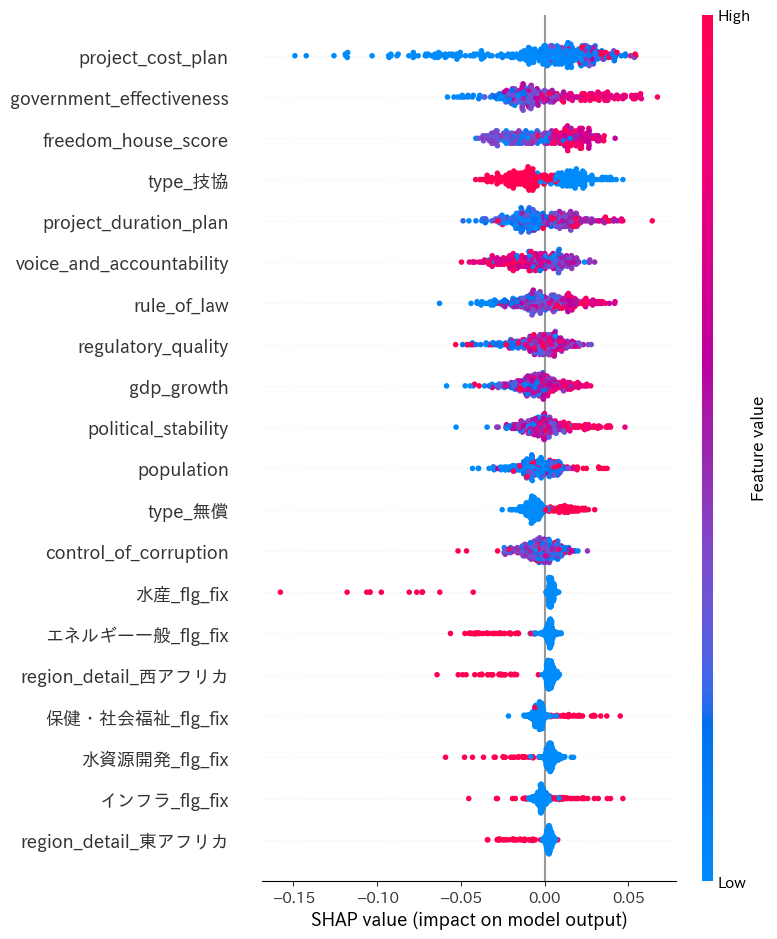

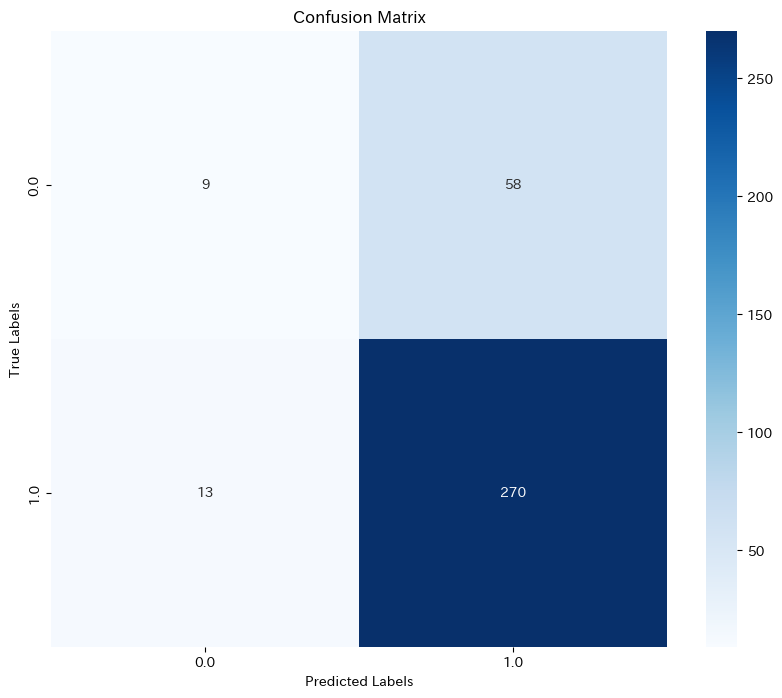

method, class, accuracy, precision, recall
proposed, all, 0.7971428571428572, 0.616130820399113, 0.544195981224619
proposed, 0.0, non, 0.4090909090909091, 0.13432835820895522
proposed, 1.0, non, 0.823170731707317, 0.9540636042402827
baseline, all, 0.6904326530612244, 0.5, 0.5
baseline, 0.0, non, 0.19142857142857142, 0.19142857142857142
baseline, 1.0, non, 0.8085714285714286, 0.8085714285714286


In [105]:
reload(ml_numerical_classification_rf)
ml_numerical_classification_rf.train_and_evaluate_model(train_df=train_rf_df, valid_df=valid_rf_df)

cm.vis('results/classification/confusion_matrix_num_rf.csv','results/classification/result_num_rf.csv')


## XGBoost
- 数値系特徴量の追加

In [106]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][rf_feat + ['label']] 


[18:10:44] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.



Accuracy: 0.75
Precision: 0.5596801827527127
Recall: 0.5468399820708203
Macro F1: 0.55
Balanced Accuracy: 0.5468399820708203
2


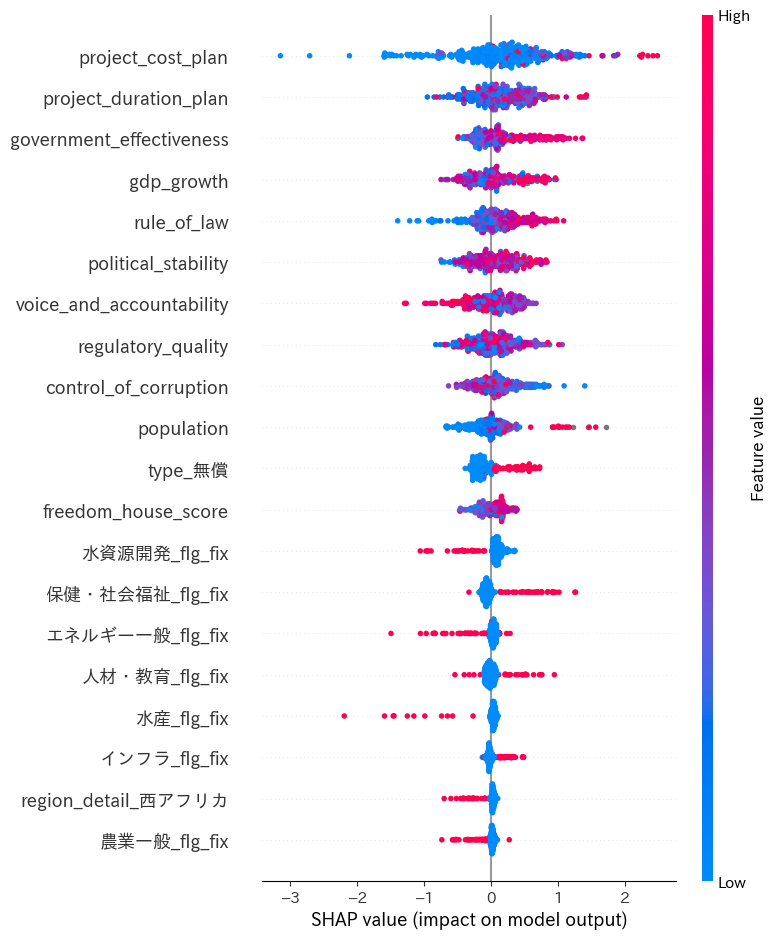

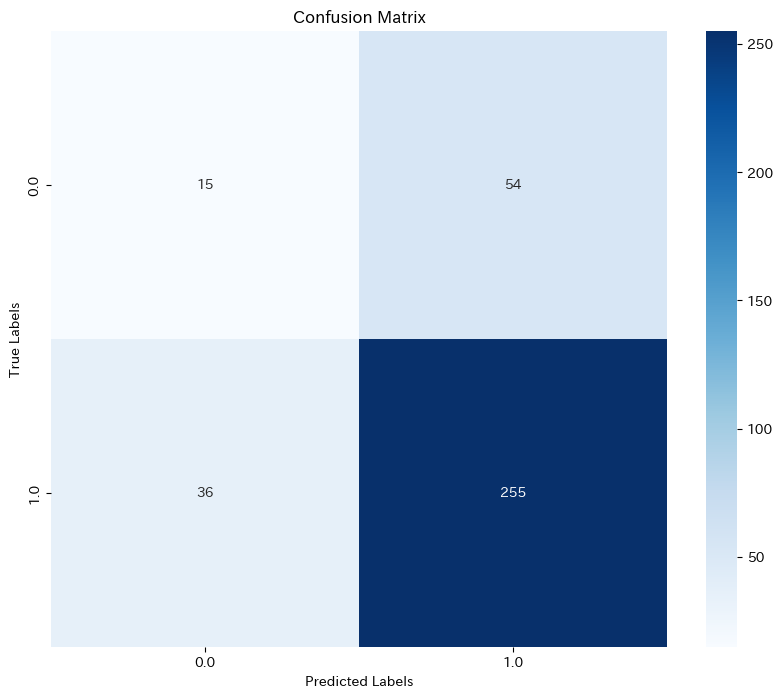

method, class, accuracy, precision, recall
proposed, all, 0.75, 0.5596801827527127, 0.5468399820708203
proposed, 0.0, non, 0.29411764705882354, 0.21739130434782608
proposed, 1.0, non, 0.8252427184466019, 0.8762886597938144
baseline, all, 0.690138888888889, 0.5, 0.5
baseline, 0.0, non, 0.19166666666666668, 0.19166666666666668
baseline, 1.0, non, 0.8083333333333333, 0.8083333333333333


In [107]:
reload(ml_numerical_classification_xgb)
ml_numerical_classification_xgb.train_and_evaluate_model(train_df=train_df, valid_df=valid_df)

cm.vis('results/classification/confusion_matrix_num_xgb.csv','results/classification/result_num_xgb.csv')


## lgbm
- 数値系特徴量の追加

In [108]:
## train_test分割
train_df = df[df[YEAR_COL] <= (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 
valid_df = df[df[YEAR_COL] > (df[YEAR_COL].max() - TEST_LAST_N)][features + ['label']] 

print(train_df.shape)
print(valid_df.shape)

(1817, 202)
(360, 202)


In [109]:
print(df[YEAR_COL].max() - TEST_LAST_N)

2020


[I 2025-10-18 18:40:24,522] A new study created in memory with name: no-name-0b3da294-c9dd-44b3-9c86-9fc186b6e2d0


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3935
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-10-18 18:40:26,325] Trial 0 finished with value: 0.5734896899206866 and parameters: {'learning_rate': 0.0747083589963355, 'num_leaves': 201, 'min_child_samples': 92, 'subsample': 0.95032984247421, 'colsample_bytree': 0.6279058960649105, 'reg_alpha': 0.0031474106464539817, 'reg_lambda': 2.51940328559729e-07, 'max_depth': 12}. Best is trial 0 with value: 0.5734896899206866.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3999
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:28,302] Trial 1 finished with value: 0.5725450644056317 and parameters: {'learning_rate': 0.06866214811119237, 'num_leaves': 66, 'min_child_samples': 83, 'subsample': 0.7252258825328142, 'colsample_bytree': 0.7823308848789441, 'reg_alpha': 0.002471334369560997, 'reg_lambda': 0.09446262889863019, 'max_depth': 9}. Best is trial 0 with value: 0.5734896899206866.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4421
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 74
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:29,666] Trial 2 finished with value: 0.5612244582624224 and parameters: {'learning_rate': 0.13128925164856822, 'num_leaves': 85, 'min_child_samples': 54, 'subsample': 0.6929461815295985, 'colsample_bytree': 0.7544378696103493, 'reg_alpha': 0.14558783376246057, 'reg_lambda': 2.3432528720000042e-07, 'max_depth': 4}. Best is trial 0 with value: 0.5734896899206866.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3933
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 47
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:31,585] Trial 3 finished with value: 0.5565627304488691 and parameters: {'learning_rate': 0.007172553931914579, 'num_leaves': 66, 'min_child_samples': 95, 'subsample': 0.9364475271495332, 'colsample_bytree': 0.9643289060856934, 'reg_alpha': 1.1694766141950463e-06, 'reg_lambda': 0.10606418919634442, 'max_depth': 9}. Best is trial 0 with value: 0.5734896899206866.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4440
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 75
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:34,791] Trial 4 finished with value: 0.5817831229803061 and parameters: {'learning_rate': 0.01117711482535834, 'num_leaves': 87, 'min_child_samples': 53, 'subsample': 0.8373671508104918, 'colsample_bytree': 0.9666923965592549, 'reg_alpha': 4.357805135264547e-08, 'reg_lambda': 8.565557358379571e-07, 'max_depth': 6}. Best is trial 4 with value: 0.5817831229803061.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000351 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3865
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:36,399] Trial 5 finished with value: 0.5653186605455036 and parameters: {'learning_rate': 0.09956438194895831, 'num_leaves': 227, 'min_child_samples': 100, 'subsample': 0.6741914486751156, 'colsample_bytree': 0.9945620717384843, 'reg_alpha': 2.561408394511046e-05, 'reg_lambda': 5.886423454842615e-07, 'max_depth': 9}. Best is trial 4 with value: 0.5817831229803061.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4082
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 56
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:37,979] Trial 6 finished with value: 0.584559866672176 and parameters: {'learning_rate': 0.04400438706594005, 'num_leaves': 219, 'min_child_samples': 75, 'subsample': 0.8647302339252683, 'colsample_bytree': 0.6574141181321245, 'reg_alpha': 4.847277708259229e-07, 'reg_lambda': 2.406259664884789e-05, 'max_depth': 3}. Best is trial 6 with value: 0.584559866672176.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000631 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4721
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:39,903] Trial 7 finished with value: 0.5698142424765964 and parameters: {'learning_rate': 0.08263173165319355, 'num_leaves': 62, 'min_child_samples': 44, 'subsample': 0.9275255264370881, 'colsample_bytree': 0.9425153041772717, 'reg_alpha': 3.585347448137465, 'reg_lambda': 0.0009511737707641879, 'max_depth': 3}. Best is trial 6 with value: 0.584559866672176.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4801
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 97
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:41,977] Trial 8 finished with value: 0.5735992959812262 and parameters: {'learning_rate': 0.14583413612698803, 'num_leaves': 224, 'min_child_samples': 43, 'subsample': 0.8972866104004329, 'colsample_bytree': 0.9797614347811964, 'reg_alpha': 1.904765455436746e-08, 'reg_lambda': 0.0005228375920365701, 'max_depth': 8}. Best is trial 6 with value: 0.584559866672176.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4917
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 111
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-10-18 18:40:44,702] Trial 9 finished with value: 0.5638760313142614 and parameters: {'learning_rate': 0.00633275739052606, 'num_leaves': 153, 'min_child_samples': 38, 'subsample': 0.8148463822604912, 'colsample_bytree': 0.9275597988674402, 'reg_alpha': 7.412051179380671, 'reg_lambda': 1.3372300134138097e-08, 'max_depth': 6}. Best is trial 6 with value: 0.584559866672176.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4134
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:40:47,841] Trial 10 finished with value: 0.5933198341311113 and parameters: {'learning_rate': 0.02688808943808606, 'num_leaves': 165, 'min_child_samples': 72, 'subsample': 0.6040474923076848, 'colsample_bytree': 0.603237267426784, 'reg_alpha': 7.494928023957252e-06, 'reg_lambda': 2.8106038910230908e-05, 'max_depth': -1}. Best is trial 10 with value: 0.5933198341311113.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4134
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-10-18 18:40:50,900] Trial 11 finished with value: 0.5937849318131009 and parameters: {'learning_rate': 0.02617348928528599, 'num_leaves': 171, 'min_child_samples': 72, 'subsample': 0.6053246423659255, 'colsample_bytree': 0.6101335180301664, 'reg_alpha': 5.156659189647742e-06, 'reg_lambda': 2.0832256630230572e-05, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4212
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-10-18 18:40:53,826] Trial 12 finished with value: 0.5889720886063595 and parameters: {'learning_rate': 0.020240529192181164, 'num_leaves': 159, 'min_child_samples': 66, 'subsample': 0.6061772324593372, 'colsample_bytree': 0.6921503865530785, 'reg_alpha': 2.167492329120377e-05, 'reg_lambda': 3.8698237960384885e-05, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6539
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 334
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[I 2025-10-18 18:40:57,265] Trial 13 finished with value: 0.5727919676001815 and parameters: {'learning_rate': 0.028404369960877338, 'num_leaves': 118, 'min_child_samples': 13, 'subsample': 0.6375648900372965, 'colsample_bytree': 0.6025929234150847, 'reg_alpha': 3.4122842774538954e-05, 'reg_lambda': 7.1347665325266565, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4212
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:41:00,036] Trial 14 finished with value: 0.5861148677784167 and parameters: {'learning_rate': 0.015303088391130018, 'num_leaves': 178, 'min_child_samples': 66, 'subsample': 0.7477159460354299, 'colsample_bytree': 0.7008022925408126, 'reg_alpha': 1.4715822488181875e-06, 'reg_lambda': 5.720750517737973e-05, 'max_depth': 5}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4134
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 58
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:41:02,205] Trial 15 finished with value: 0.569454271182368 and parameters: {'learning_rate': 0.03557213498942123, 'num_leaves': 252, 'min_child_samples': 73, 'subsample': 0.6008446977574522, 'colsample_bytree': 0.7171562037664493, 'reg_alpha': 0.0002703836449985728, 'reg_lambda': 0.004016044335901416, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5560
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 178
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-10-18 18:41:05,422] Trial 16 finished with value: 0.5864352271374558 and parameters: {'learning_rate': 0.02266283136385915, 'num_leaves': 114, 'min_child_samples': 24, 'subsample': 0.7713475272076713, 'colsample_bytree': 0.6481087901616764, 'reg_alpha': 2.2674188989594693e-07, 'reg_lambda': 7.391848393870662e-06, 'max_depth': 7}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3966
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-10-18 18:41:07,515] Trial 17 finished with value: 0.573162929716005 and parameters: {'learning_rate': 0.049429081950000515, 'num_leaves': 181, 'min_child_samples': 86, 'subsample': 0.6674105825430898, 'colsample_bytree': 0.8405245917713959, 'reg_alpha': 7.999683954877181e-06, 'reg_lambda': 0.010908943237423075, 'max_depth': 10}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4212
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[I 2025-10-18 18:41:10,208] Trial 18 finished with value: 0.5669043799805449 and parameters: {'learning_rate': 0.012400538434521855, 'num_leaves': 134, 'min_child_samples': 63, 'subsample': 0.7188327659577441, 'colsample_bytree': 0.8648160750034627, 'reg_alpha': 0.0004919376275465176, 'reg_lambda': 4.748386436680895e-06, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[LightGBM] [Info] Number of positive: 906, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4001
[LightGBM] [Info] Number of data points in the train set: 1211, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748142 -> initscore=1.088728
[LightGBM] [Info] Start training from score 1.088728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-10-18 18:41:12,936] Trial 19 finished with value: 0.5860619239929585 and parameters: {'learning_rate': 0.019708241332776488, 'num_leaves': 34, 'min_child_samples': 82, 'subsample': 0.9952541047857394, 'colsample_bytree': 0.6095515759663733, 'reg_alpha': 0.029236535884326353, 'reg_lambda': 2.215803510967754e-08, 'max_depth': -1}. Best is trial 11 with value: 0.5937849318131009.


[Optuna] Best params: {'learning_rate': 0.02617348928528599, 'num_leaves': 171, 'min_child_samples': 72, 'subsample': 0.6053246423659255, 'colsample_bytree': 0.6101335180301664, 'reg_alpha': 5.156659189647742e-06, 'reg_lambda': 2.0832256630230572e-05, 'max_depth': -1}
[Optuna] Best OOF Macro F1: 0.5938
[LightGBM] [Info] Number of positive: 1087, number of negative: 366
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001299 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4658
[LightGBM] [Info] Number of data points in the train set: 1453, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.748107 -> initscore=1.088544
[LightGBM] [Info] Start training from score 1.088544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


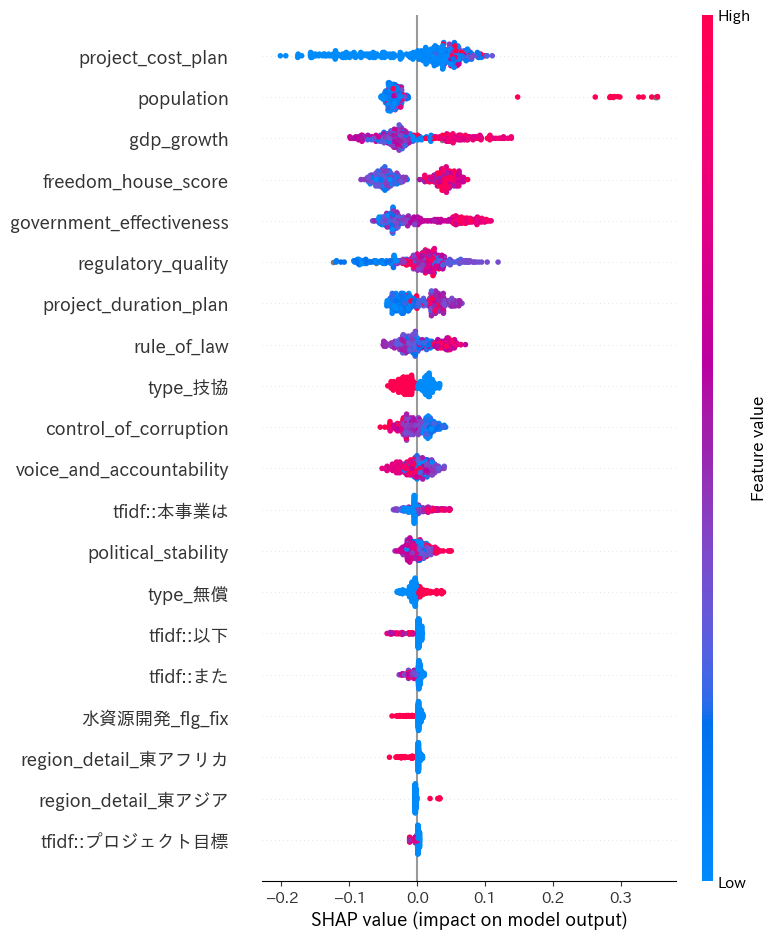

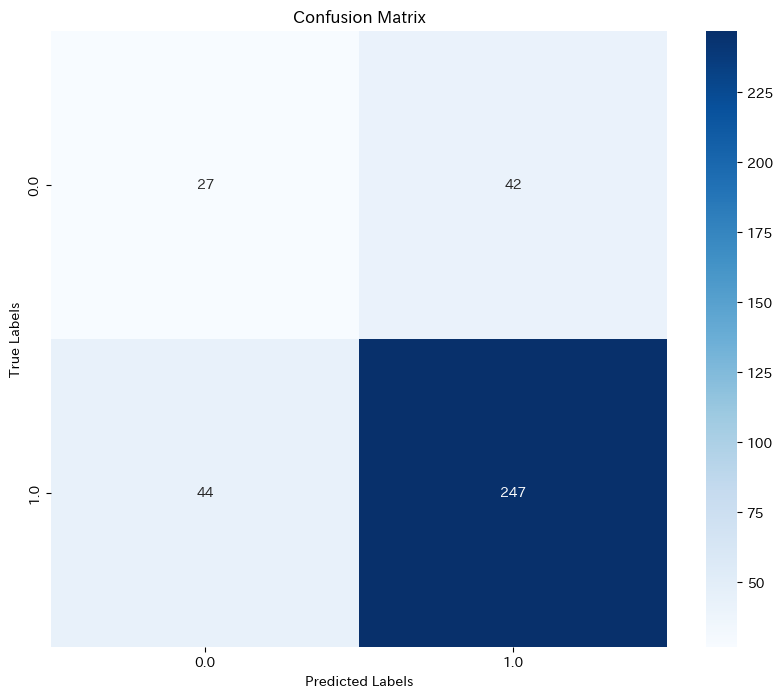

method, class, accuracy, precision, recall
proposed, all, 0.7611111111111111, 0.6174764852088308, 0.6200507993425968
proposed, 0.0, non, 0.38028169014084506, 0.391304347826087
proposed, 1.0, non, 0.8546712802768166, 0.8487972508591065
baseline, all, 0.690138888888889, 0.5, 0.5
baseline, 0.0, non, 0.19166666666666668, 0.19166666666666668
baseline, 1.0, non, 0.8083333333333333, 0.8083333333333333


In [118]:
reload(ml_numerical_classification_lgb)
ml_numerical_classification_lgb.train_and_evaluate_model(train_df=train_df, use_optuna=True, n_trials=20, valid_df=valid_df, n_splits=N_SPLITS, threshold_objective="macro_f1")

cm.vis('results/classification/confusion_matrix_num_lgb.csv','results/classification/result_num_lgb.csv')
